# Tp3 : Mediciones de sensor de barrido láser 

1) Lanzamos Gazebo para simular el robot TurtleBot3 en el entorno mundo 

` roslaunch turtlebot3_gazebo turtlebot3_world.launch`

<img src="./imgs/turtlebot_world.png" alt="Gazebo" width="500" height = "500"/>

2) Lanzamos el nodo de teleoperación para mover el robot con el teclado 

` roslaunch turtlebot3_teleop turtlebot3_teleop_key.launch ` 

3) Ejecutamos la herramienta de registro de datos que crea un registro de odometría y puntos del sensor láser con extensión .bag . Rosbag permite grabar los mensajes de los tópicos que se le pasen por la línea de comandos

` rosbag record /cmd_vel /odom /scan ` 

En este caso, estaremos creando un registro del tópico de los **comando de velocidad**, de  **odometría** y **scan** que corresponde al sensor láser. 

El registro creado tiene de nombre **world.bag**


4) Descargamos el paquete de ROS para convertir el registro con extensión bag en texto plano. Para ello clonamos el repositorio en el espacio de trabajo de ROS (catkin_ws creado en práctico anteriores) 

```bash
    cd ~/catkin_ws/src  
    git clone https://github.com/ciiiutnfrc/rosbag2txt.git 
 ```   

  Después construimos el paquete con la herramienta `catkin_make`. Para comprobar que se ha construido exitosamente podemos corroborar: 
  
  ` rospack find rosbag2txt` 
  
 5) Convertimos el formato del archivo de texto: 
 
 `roslaunch rosbag2txt rosbag2txt.launch bagfile:=/home/<user>/world.bag`

   Realizamos ciertos **cambios** en el script por problemas de incompatibilidad con la versión de python en nuestra PC. 
 
 * La primer línea ` #!/usr/bin/env python` del script *odom_scan_log.py* la cambiamos por `#!/usr/bin/env python3 `. 
  
 * La línea 53 ` except rospy.ServiceException, e:` la cambiamos a ` except rospy.ServiceException as e:`

6) Cargamos los datos de scan.txt y graficamos 3 barridos laser 

In [1]:
import pandas as pd 
import matplotlib.pylab as plt
import numpy as np 

#El separador es un caracter de tab
# 
Scandata = pd.read_csv("./log/scan.txt", sep= "\t", 
                       header=None, index_col = None) 
Scandata = Scandata.replace(np.inf,3.5) #El inf lo reemplazo por el valor máxima 
puntos  =[]
puntos.append(Scandata.loc[0,1:]) #Todos los puntos de la fila 0 menos el valor de time
puntos.append(Scandata.loc[1,1:])
puntos.append(Scandata.loc[2,1:])



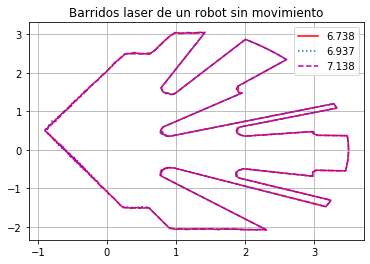

In [2]:
linea = ['r-', ':','m--']


plt.figure(1)
plt.title("Barridos laser de un robot sin movimiento")
plt.grid('true')
for j in range(len(puntos)):
    ax  = [] 
    ay = [] 
    for i,rho in enumerate(puntos[j]):
        res = 2*np.pi / 360 
        x = rho * np.cos(res*i)
        y = rho* np.sin(res*i)
        ax.append(x)
        ay.append(y)
   
    plt.plot(ax,ay,linea[j], label = Scandata.loc[j,0])
plt.legend()
plt.savefig("./imgs/barridos_consecutivos_robot_estatico.png")

Al tomar 3 barridos consecutivos en una franja de tiempo donde el robot permaneció casi estático no existe diferencia entre los barridos láser. Ahora graficamos 3 barridos con una diferencia de tiempo significable 

In [3]:
puntos  =[]
puntos.append(Scandata.loc[0,1:])
puntos.append(Scandata.loc[len(Scandata)//2,1:])
puntos.append(Scandata.loc[len(Scandata)-1,1:])


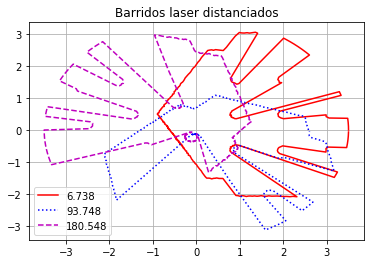

In [4]:
linea = ['r-', 'b:','m--']
time = [Scandata.loc[0,0], Scandata.loc[len(Scandata)//2,0],
        Scandata.loc[len(Scandata)-1,0]]

plt.figure(1)
plt.title("Barridos laser distanciados")
plt.grid('true')
for j in range(len(puntos)):
    ax  = [] 
    ay = [] 
    for i,rho in enumerate(puntos[j]):
        res = 2*np.pi / 360 
        x = rho * np.cos(res*i)
        y = rho* np.sin(res*i)
        ax.append(x)
        ay.append(y)
   
    plt.plot(ax,ay,linea[j], label = time[j])
plt.legend()
plt.savefig("./imgs/3barridos_laser.png")

7) Diseñamos un algoritmo que determina los indices del vector de timestamp de odometría que se encuentran más proximos a los valores del vector de timestamp de las mediciones laser. 

Esto se puede hacer de varias formas.La fomas más facil, aunque no la más rapida, es con las funciones propias de Pandas, trabajando con dataFrames. De toda la columna de tiempo (DataFrame[0]) de odometría, restamos el valor de tiempo de barrido laser, lo convertimos a absoluto y devolvemos el indice del mínimo encontrado.

In [5]:
def encontrar_valorCercano(valor,df):
    return (df[0].sub(valor).abs().idxmin())

Cargamos los datos de **odometría** y recorremos todo el arreglo de los timestamp del barrido laser

In [6]:
Odomdata = pd.read_csv("./log/odom.txt", sep= "\t", 
                       header=None, index_col = None) 
near_i = []

for timestamp in Scandata[0]:
    near_i.append( encontrar_valorCercano(timestamp,Odomdata))

near_i = np.array(near_i)

8) Para mostar las cercanias de los valores de timestamp graficamos algunos puntos de ambos vectores. 

* Graficamos N = 10 puntos de tiempo del **sensor laser** 
* Graficamos los timestamps de **odometría** hasta el valor que corresponde con el N valor cercano encontrado 
* Graficamos los puntos de **odometría** más cercanos a los N puntos de sensor laser 


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


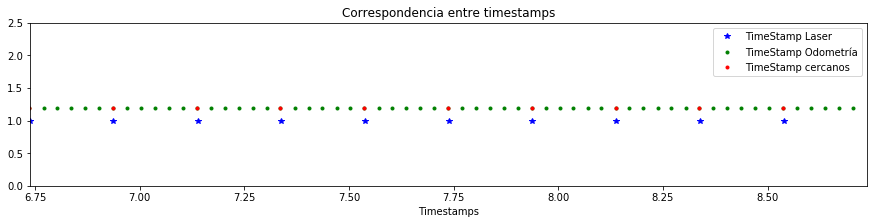

In [7]:
N=10
plt.figure(figsize=(15, 3))
plt.title("Correspondencia entre timestamps")
plt.xlabel("Timestamps")

plt.xlim(Scandata[0][0], Scandata[0][N])
plt.ylim(0,2.5)

plt.plot(Scandata[0][0:N],np.ones(N),linestyle="", 
         marker = '*',color = "blue", 
         label = "TimeStamp Laser" )

plt.plot(Odomdata[0][0:near_i[N]],1.2*np.ones(near_i[N]),
         linestyle="",marker = '.', color = "green",
         label = "TimeStamp Odometría")

plt.plot(Odomdata[0][near_i[(near_i < near_i[N])]], # N puntos de laser que corresponden 
         1.2*np.ones(N),linestyle="",marker = '.',  # con los N puntos de cercania
         color = "red", label = "TimeStamp cercanos")


plt.legend()
plt.savefig("./imgs/fig_correspondencia_timestamps.png")


9) Graficamos la nube de puntos del sensor laser en el mapa, con respeto al centro odométrico del robot 

* Construimos una función para pasar de coordenadas polares a rectangulares como la utilizada anteriormente 

In [8]:
def polar2rec(rho,theta):    #Rho, Tita --> (x,y)
   
    x = rho * np.cos(theta)
    y = rho* np.sin(theta)
    return x,y



* Cargamos todos los puntos de barridos Laser para todos los tiempos de muestreo en un mismo arreglo 

In [9]:
puntosLaser = [] 
for n in range(len(Scandata[0])):
    puntosLaser.append(Scandata.loc[n,1:]) #Todos los puntos de la fila j menos el de tiempo 
 


* Creamos una función encargada de realizar la multiplicación matricial (composición) para referenciar el punto laser al sistema de referencia de odometría del robot. Tenemos en cuenta que el robot solo rota en tita, cuyo valor se encuentra registrado en Odomdata[3]: 

    * El punto **p_L** es un punto de coordenadas polares en el sisema de referencia del laser 
    * La matriz **O_A_L** es la matriz de rotación que mapea los puntos en el sistema del laser al sistema de odometría y tiene la forma: 

$\begin{equation}
T_L ^O = \begin{bmatrix}
R_L ^O & p^O \\
0 &  1
\end{bmatrix}
\end{equation}$  
 
Donde: 

$\begin{equation}
R_L ^O = \begin{bmatrix}
cos(\theta) & -sen(\theta) & 0\\
sen(\theta) & cos(\theta) & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}$ 

$\begin{equation}
p^O = \begin{bmatrix}
x_{odom} \\
y_{odom} \\
0
\end{bmatrix}
\end{equation}$ 


In [10]:
def composicion(puntos,near_i,j):
    axLaser = []
    ayLaser = []
    RES = 2 *np.pi / 360
    for i,rho in enumerate(puntos):                                     
        if(rho < 3.5):                                                            
            x ,y = polar2rec(rho,RES*i)                                            
            p_L = np.array([[x], [y], [0], [1]])                                  
            O_A_L = np.array([[np.cos(Odomdata[3][near_i[j]]),                      
                -np.sin(Odomdata[3][near_i[j]]), 0 , Odomdata[1][near_i[j]]],   
                        [np.sin(Odomdata[3][near_i[j]]), np.cos(Odomdata[3][near_i[j]]), 0 
                        ,Odomdata[2][near_i[j]]],                               
                        [0, 0, 1 ,0],                                           
                        [0,0, 0 ,1]])                                           
                                                                                
            r=np.matmul(O_A_L,p_L)                                                    
                                                                                
            axLaser.append(r[0])                                                
            ayLaser.append(r[1])  
    
    return axLaser, ayLaser        #el punto p en el sistema de referencia o (odometria )

* Para cada barrido laser (fila de Scandata o elemento de puntosLaser) realizamos la rotación y graficamos las coordenadas

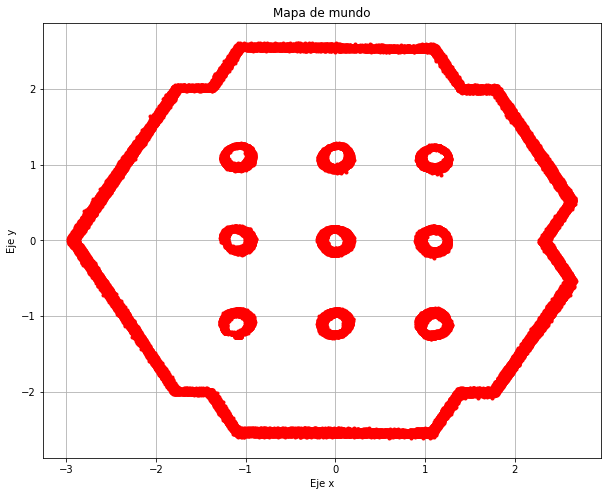

In [14]:
plt.figure(figsize = (10,8))
plt.title("Mapa de mundo")
plt.xlabel("Eje x")
plt.ylabel("Eje y")
plt.grid("true")
for j in range(len(puntosLaser)): 
    x,y = composicion(puntosLaser[j],near_i,j)
    plt.plot(x,y,linestyle="",                                  
             marker = '.',color = "red",) 
plt.savefig("./imgs/construccion_mapa.png")

* Ahora, agregamos el camino realizado por el robot 

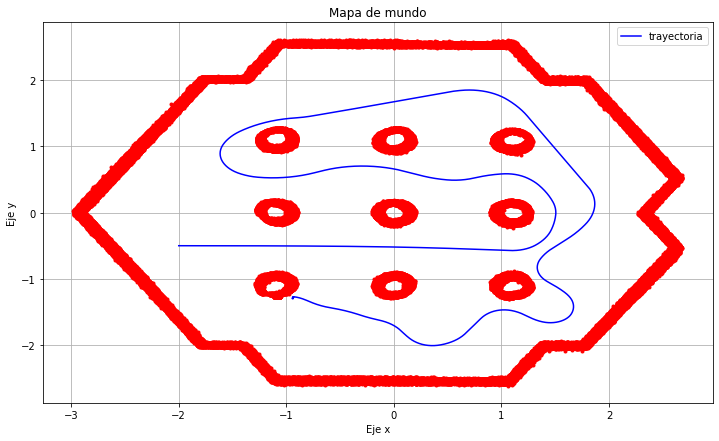

In [16]:
plt.figure(figsize = (12,7))
plt.title("Mapa de mundo")
plt.xlabel("Eje x")
plt.ylabel("Eje y")
plt.grid("true")
for j in range(len(puntosLaser)): 
    x,y = composicion(puntosLaser[j],near_i,j)
    plt.plot(x,y,linestyle="",                                  
             marker = '.',color = "red",) 

plt.plot(Odomdata.loc[:,1],Odomdata.loc[:,2],color = "blue",label="trayectoria")
plt.legend(loc='upper right')    
plt.savefig("./imgs/mapa_trayectoria.png")